# Image Classification for Coffee or Donuts

Is the given image a coffee photo, or a donut?
In this demo notebook we build a simple deep neural network to classify an image as one of the following:
- coffee
- mug
- donut


## Install Prerequisites

We use Keras/Tensorflow to build the classification model, and visualize the process with matplotlib.

In [2]:
# Import required libraries
# Uncomment below tensorflow installation if you don't have TensorFlow 1.15
# !pip install tensorflow==1.15
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
import zipfile

## Read The Data

In [4]:
with zipfile.ZipFile('/Users/saishruthi.tn@ibm.com/Desktop/Think_2020/coffee-donut-instructions/assets/data/coffee-donuts-segregated.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

## Build the Model

We start with a [MobileNetV2](https://arxiv.org/abs/1801.04381) architecture as the backbone [pretrained feature extractor](https://github.com/tensorflow/models/tree/master/research/slim/nets/mobilenet). We then add a couple of dense layers and a softmax layer to perfom the classification. We freeze the MobileNetV2 backbone with weights trained on ImageNet dataset and only train the dense layers and softmax layer that we have added.

In [6]:
base_model=tf.keras.applications.MobileNetV2(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.
x=base_model.output
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dense(512,activation='relu')(x) #dense layer 1
x=tf.keras.layers.Dense(256,activation='relu')(x) #dense layer 2
preds=tf.keras.layers.Dense(3,activation='softmax')(x) #final layer with softmax activation

model=tf.keras.Model(inputs=base_model.input,outputs=preds)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/Users/saishruthi.tn@ibm.com/anaconda3/envs/watson_nlp/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 1s 0us/step


In [7]:
#Freeze layers from MobileNetV2 backbone (not to be trained)
for layer in base_model.layers:
    layer.trainable=False

In [8]:
#Prepare the training dataset as a data generator object
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory('data',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=10,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 39 images belonging to 3 classes.


### Using Adam, categorical_crossentropy and accuracy as optimization method, loss function and metrics, respectively

In [9]:
# Build the model
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
______________________________________________________________________________________________

## Train the model

In [10]:
from tensorflow import set_random_seed
set_random_seed(2)
step_size_train=5
log_file = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=4)

Epoch 1/4
5/5 [==============================] - 3s 606ms/step - loss: 1.0940 - acc: 0.5000
Epoch 2/4
5/5 [==============================] - 2s 366ms/step - loss: 0.2361 - acc: 0.9000
Epoch 3/4
5/5 [==============================] - 2s 340ms/step - loss: 0.0576 - acc: 1.0000
Epoch 4/4
5/5 [==============================] - 2s 337ms/step - loss: 0.0136 - acc: 1.0000


## Figure of Training Loss and Accuracy

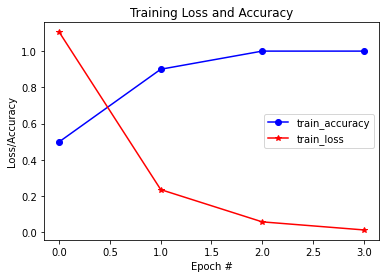

In [11]:
# Model accuracy and loss vs epoch
plt.plot(log_file.history['acc'], '-bo', label="train_accuracy")
plt.plot(log_file.history['loss'], '-r*', label="train_loss")
plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend(loc='center right')
plt.show()

# Model Optimal Performance

Here we perform inference on some sample data points to determine the performance of the model

In [12]:
# Mapping labels 
label_map = (train_generator.class_indices)

In [13]:
label_map

{'coffee': 0, 'donut': 1, 'mug': 2}

In [14]:
# Creating a sample inference function
def prediction(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    preds = model.predict(x)
    #print('Predictions', preds)
    
    for pred, value in label_map.items():    
        if value == np.argmax(preds):
            print('Predicted class is:', pred)
            print('With a confidence score of: ', np.max(preds))
    
    return np.argmax(preds)

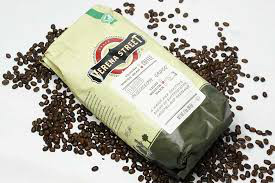

In [17]:
#Opening first image
image = Image.open("/coffee-donut-instructions/assets/data/Coffee.jpg")
image

In [18]:
#performing inference on above image
prediction('/coffee-donut-instructions/assets/data/Coffee.jpg', model)

Predicted class is: coffee
With a confidence score of:  0.99982387


0

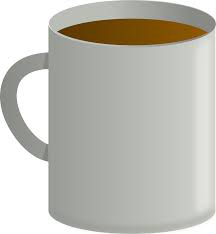

In [19]:
#Opening second image
image = Image.open("/coffee-donut-instructions/assets/data/Mug.jpg")
image

In [21]:
prediction('/coffee-donut-instructions/assets/data/Mug.jpg', model)

Predicted class is: mug
With a confidence score of:  0.9999325


2

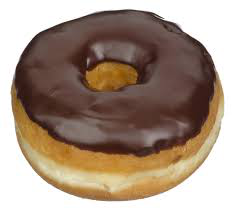

In [22]:
#Opening third image
image = Image.open("/coffee-donut-instructions/assets/data/Donut.jpg")
image

In [24]:
prediction('/coffee-donut-instructions/assets/data/Donut.jpg', model)

Predicted class is: donut
With a confidence score of:  0.9999157


1

# Model Poor Performance

### Example 1

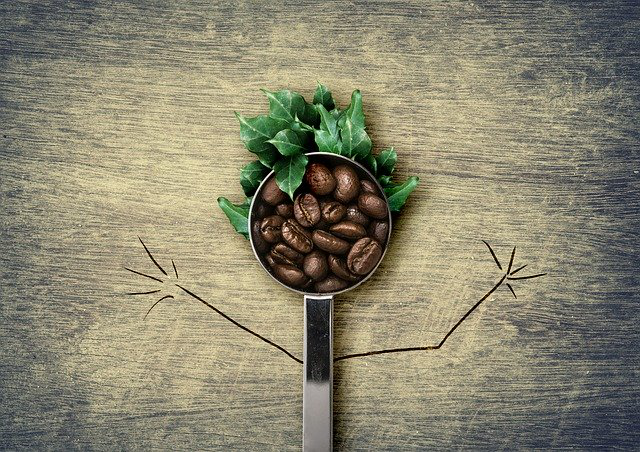

In [25]:
#Opening third image
image = Image.open("/coffee-donut-instructions/assets/data/coffee-bean.jpg")
image

In [26]:
prediction('/coffee-donut-instructions/assets/data/coffee-bean.jpg', model)

Predicted class is: donut
With a confidence score of:  0.98051935


1

### Example 2

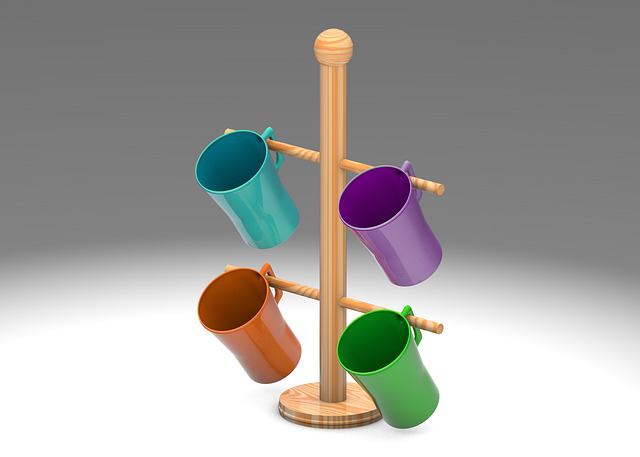

In [36]:
image = Image.open("/coffee-donut-instructions/assets/data/coffee-mugs.jpg")
image

In [37]:
prediction('/coffee-donut-instructions/assets/data/coffee-mugs.jpg', model)

Predicted class is: donut
With a confidence score of:  0.8759597


1